In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# Handle table-like data and matrices
import numpy as np
import numpy.linalg as sla
import pandas as pd

# Modelling Algorithmsx
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split , StratifiedKFold

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline

In [4]:
X_data = pd.read_csv('data/trainX.csv')
Y_data = pd.read_csv('data/trainY.csv')

In [5]:
X_data.head()

,id,pickup_dt,borough,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,26112,2015-06-12 16:00:00,NaN,6.0,9.1,82.0,60.0,1014.2,0.0,0.00,0.240000,0.000000,N
1,26896,2015-06-17 12:00:00,EWR,7.0,10.0,72.0,58.0,1018.9,0.0,0.00,0.270000,0.000000,N
2,2263,2015-01-15 08:00:00,Queens,3.0,10.0,27.0,17.0,1021.6,0.0,0.00,0.000000,0.000000,N
3,10453,2015-03-07 15:00:00,Brooklyn,7.0,9.1,24.0,7.0,1024.3,0.0,0.29,0.551667,18.583333,N
4,19043,2015-04-30 08:00:00,EWR,9.0,10.0,49.0,40.0,1006.7,0.0,0.00,0.050000,0.000000,N


Давайте немного поиграемся с данными

* Сразу уберем такой признак как id поездки.
* Преобразуем данные о времени в численный признак
* Преобразуем hday (holiday) в бинарный числовой признак

In [6]:
X = pd.DataFrame(X_data, copy=True)
del X['id']
X['pickup_dt'] = X['pickup_dt'].apply(
    lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").time()
).apply(
    lambda x: x.second+x.minute*60+x.hour*3600
)
X['hday'] = X['hday'].apply(lambda x: 0 if x == 'N' else 1)    
X.head()

,pickup_dt,borough,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,57600,NaN,6.0,9.1,82.0,60.0,1014.2,0.0,0.00,0.240000,0.000000,0
1,43200,EWR,7.0,10.0,72.0,58.0,1018.9,0.0,0.00,0.270000,0.000000,0
2,28800,Queens,3.0,10.0,27.0,17.0,1021.6,0.0,0.00,0.000000,0.000000,0
3,54000,Brooklyn,7.0,9.1,24.0,7.0,1024.3,0.0,0.29,0.551667,18.583333,0
4,28800,EWR,9.0,10.0,49.0,40.0,1006.7,0.0,0.00,0.050000,0.000000,0


In [7]:
X.describe()

,pickup_dt,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
count,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000
mean,41689.793814,5.993788,8.828963,47.634604,30.770120,1017.860657,0.003779,0.026113,0.089921,2.543623,0.037758
std,24833.431797,3.705928,2.428889,19.866550,21.328122,7.752882,0.018938,0.093398,0.217826,4.526571,0.190614
min,0.000000,0.000000,0.000000,2.000000,-16.000000,991.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21600.000000,3.000000,9.100000,32.000000,14.000000,1012.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43200.000000,6.000000,10.000000,46.000000,30.000000,1018.300000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64800.000000,8.000000,10.000000,64.666667,50.000000,1023.000000,0.000000,0.000000,0.050000,3.437500,0.000000
max,82800.000000,21.000000,10.000000,89.000000,73.000000,1043.400000,0.280000,1.240000,2.100000,19.000000,1.000000


Посмотрим, какие данные коррелируют между собой:

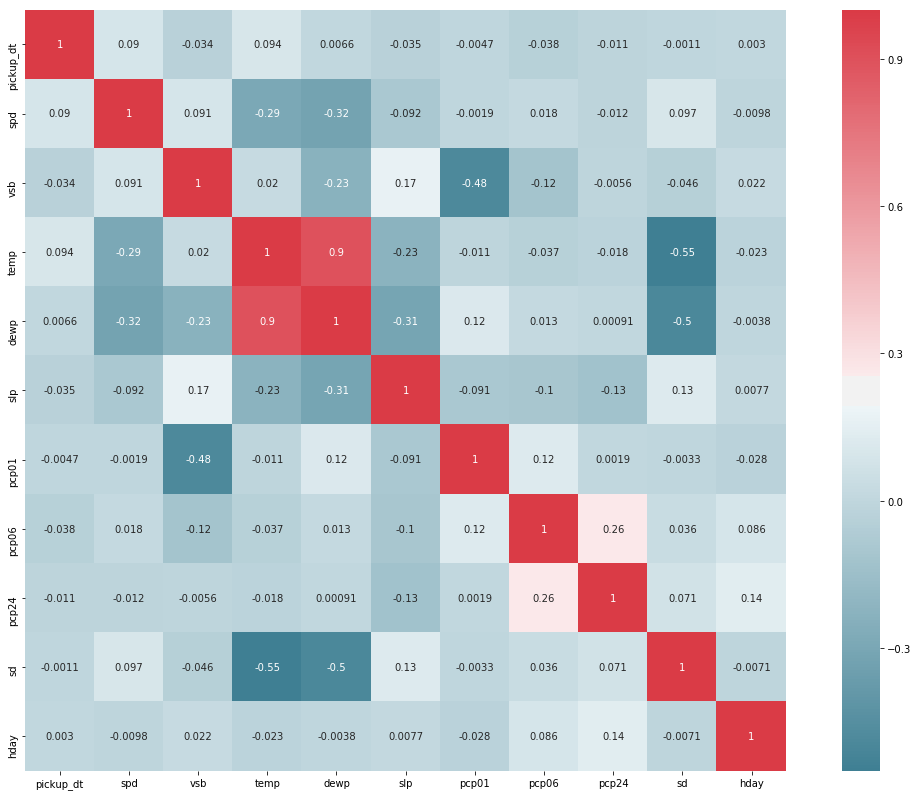

In [8]:
def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots(figsize=(20, 14))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        ax=ax, 
        annot = True, 
        annot_kws = {'fontsize': 10}
    )

plot_correlation_map(X)

Что заметили: Признаки dewp и temp очень сильно коррелируют, но все же убирать этот признак пока не будем

Тем временем наступило время нормализации! 

In [9]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

for column_name in ['pickup_dt', 'spd', 'vsb', 'temp', 'dewp', 
                    'slp', 'pcp01', 'pcp06', 'pcp24', 'sd']:
    X[column_name] = normalize(X[column_name])

In [10]:
X.describe()

,pickup_dt,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
count,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000,23280.000000
mean,0.005631,0.005575,0.006319,0.006049,0.005387,0.006554,0.001283,0.001765,0.002501,0.003211,0.037758
std,0.003354,0.003447,0.001738,0.002523,0.003734,0.000050,0.006427,0.006312,0.006058,0.005714,0.190614
min,0.000000,0.000000,0.000000,0.000254,-0.002801,0.006383,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002917,0.002790,0.006513,0.004064,0.002451,0.006519,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.005835,0.005580,0.007157,0.005841,0.005252,0.006557,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008752,0.007440,0.007157,0.008212,0.008753,0.006587,0.000000,0.000000,0.001391,0.004339,0.000000
max,0.011183,0.019531,0.007157,0.011302,0.012779,0.006718,0.095031,0.083803,0.058406,0.023983,1.000000


Рассмотрим категориальный признак borough

In [11]:
set(X['borough'].values)

{nan, 'Brooklyn', 'EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island'}

Значений мало, подойдет one-hot encoding

In [12]:
for value in set(X['borough'].values):
    new_value = 'borough_{}'.format(value)
    X[new_value] = (X['borough'] == value)

In [13]:
del X['borough']
del X['borough_nan']
X.head()

,pickup_dt,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,borough_Brooklyn,borough_EWR,borough_Queens,borough_Bronx,borough_Manhattan,borough_Staten Island
0,0.007780,0.005580,0.006513,0.010413,0.010504,0.006530,0.0,0.000000,0.006675,0.000000,0,False,False,False,False,False,False
1,0.005835,0.006510,0.007157,0.009143,0.010153,0.006561,0.0,0.000000,0.007509,0.000000,0,False,True,False,False,False,False
2,0.003890,0.002790,0.007157,0.003429,0.002976,0.006578,0.0,0.000000,0.000000,0.000000,0,False,False,True,False,False,False
3,0.007293,0.006510,0.006513,0.003048,0.001225,0.006595,0.0,0.019599,0.015343,0.023457,0,True,False,False,False,False,False
4,0.003890,0.008371,0.007157,0.006222,0.007002,0.006482,0.0,0.000000,0.001391,0.000000,0,False,True,False,False,False,False


Подготовим вектор ответов

In [14]:
Y_data.head()
merged = pd.merge(X_data, Y_data, on=['id'])
Y = merged['pickups'].values

In [15]:
X = X.astype(float)
X.head()

,pickup_dt,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,borough_Brooklyn,borough_EWR,borough_Queens,borough_Bronx,borough_Manhattan,borough_Staten Island
0,0.007780,0.005580,0.006513,0.010413,0.010504,0.006530,0.0,0.000000,0.006675,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005835,0.006510,0.007157,0.009143,0.010153,0.006561,0.0,0.000000,0.007509,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.003890,0.002790,0.007157,0.003429,0.002976,0.006578,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.007293,0.006510,0.006513,0.003048,0.001225,0.006595,0.0,0.019599,0.015343,0.023457,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.003890,0.008371,0.007157,0.006222,0.007002,0.006482,0.0,0.000000,0.001391,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
Y = Y.astype(float)
Y

array([  2.,   0., 210., ...,  88.,  69., 223.])

Начинаем учить(-ся)

In [17]:
num_test = 0.20
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=num_test, random_state=23)

In [18]:
scorer = make_scorer(accuracy_score)

def run_search(X, Y, clf, parameters):
    grid_obj = GridSearchCV(clf, parameters, cv=KFold(n_splits=3), 
                            scoring=scorer)
    grid_obj = grid_obj.fit(X, Y)
    print('Best score: {}'.format(grid_obj.best_score_))
    return grid_obj.best_estimator_ 

In [19]:
%timeit

best_clfs={}
best_clfs['RandomForestClassifier'] = run_search(
    X, Y, RandomForestClassifier(),  
    {
        'n_estimators': [50, 10],
        'criterion': ['entropy', 'gini'],
        'min_samples_leaf': [3, 5],
        'max_depth': [5, 7]
    })
best_clfs['DecisionTreeClassifier'] = run_search(
    X, Y, DecisionTreeClassifier(),  
    {
        'criterion': ['entropy', 'gini'],
        'min_samples_leaf': [3, 5],
        'max_depth': [3, 4],
        'min_samples_split': [3, 5, 8]
    })

Best score: 0.24690721649484537
Best score: 0.2472938144329897


In [20]:
best_clfs['LogisticRegression'] = run_search(
    X_train, y_train, LogisticRegression(), 
    {
        'solver' : ['liblinear', 'saga'],
        'penalty' : ['l1', 'l2']
    })

Best score: 0.23872422680412372


In [ ]:
best_clfs['GradientBoostingClassifier'] = run_search(
    X_train, y_train, GradientBoostingClassifier(), 
    {
        'n_estimators': [30],
        'min_samples_split': [3],
        'min_samples_leaf': [3],
        'max_depth': [4]
    })

In [22]:
best_clfs

{'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=3,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'RandomForestClassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=

In [23]:
scorer = make_scorer(mean_squared_error)

mean_best_clfs={}
mean_best_clfs['RandomForestClassifier'] = run_search(
    X_train, y_train, RandomForestClassifier(),  
    {
        'n_estimators': [50, 10],
        'criterion': ['entropy', 'gini'],
        'min_samples_leaf': [3, 5],
        'max_depth': [5, 7]
    })
mean_best_clfs['DecisionTreeClassifier'] = run_search(
    X_train, y_train, DecisionTreeClassifier(),  
    {
        'criterion': ['entropy', 'gini'],
        'min_samples_leaf': [3, 5],
        'max_depth': [3, 4],
        'min_samples_split': [3, 5, 8]
    })

Best score: 1246637.5646477663
Best score: 1245676.0787156357


In [ ]:
mean_best_clfs['LogisticRegression'] = run_search(
    X_train, y_train, LogisticRegression(), 
    {
        'solver' : ['liblinear', 'saga'],
        'penalty' : ['l1', 'l2']
    })

In [24]:
mean_best_clfs

{'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=3,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'RandomForestClassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)}

Давайте напишем простую реализацию градиентного бустинга

In [92]:
def sigmoid(a):
    return (1.0 + np.exp(-1.0*a))

def calculate_cost(x, y, theta, C=1):
    m = x.shape[0]
    h = sigmoid(np.matmul(np.matmul(x, theta), y.T))
    cost = (np.log(h))/m + C/2 * sla.norm(theta)**2
    return cost

def gradientDescent(x, y, theta, alpha, n_iterations=None, C=1):
    m = x.shape[0]
    def make_step(theta):
        h = 1.0 / sigmoid(np.matmul(np.matmul(x, theta), y.T))
        grad = np.matmul(y, x * (1 - h)) / m
        theta = theta + alpha * grad - alpha * C * theta
        cost = calculate_cost(x, y, theta)
        return theta, cost
    
    qual = []
    if n_iterations is not None:
        for i in range(0, n_iterations):
            theta, cost = make_step(theta)
            qual.append(cost)
    else:
        new_theta, cost = make_step(theta)
        qual.append(cost)
        count = 0
        while (sla.norm(theta - new_theta) > 0.0001):
            theta = new_theta
            new_theta, cost = make_step(theta)
            qual.append(cost)
            count += 1
            if count > 10000:
                print("To many operations. Break.")
                break
    return theta, qual

In [65]:
m, n = X.shape

Шаг равен 0.005, количество итераций 1000, инициализация нулевым вектором


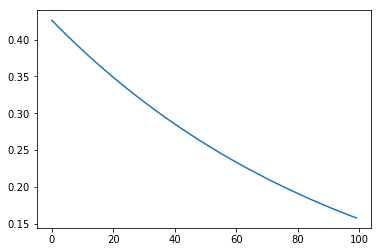

In [85]:
print("Шаг равен {}, количество итераций {}, инициализация нулевым вектором".format(0.005, 1000))
theta, qual = gradientDescent(X, Y, np.zeros(n), 0.005, 100)
plt.plot(range(0, len(qual)), qual)

Критерий останова - по норме


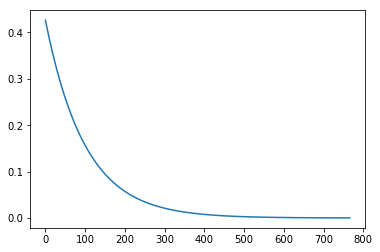

In [73]:
print("Критерий останова - по норме")
theta, qual = gradientDescent(X, Y, np.zeros(n), 0.005)
plt.plot(range(0, len(qual)), qual)

Шаг равен 0.0001, количество итераций 1000
Инициализация случайным вектором в диапазоне значений от -1/n до 1/n:


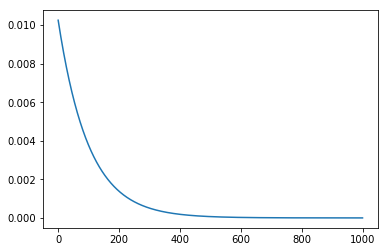

In [82]:
print("Шаг равен {}, количество итераций {}".format(0.0001, 1000))
print("Инициализация случайным вектором в диапазоне значений от -1/n до 1/n:")
theta, qual = gradientDescent(X, Y, np.random.uniform(low=-1/n, high=1/n, size=(n,)), 0.005, 1000)
plt.plot(range(0, len(qual)), qual)

Инициализация нулевым вектором:


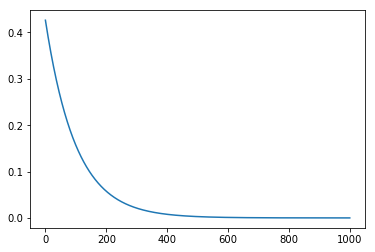

In [84]:
print("Инициализация нулевым вектором:")
theta, qual = gradientDescent(X, Y, np.zeros(n), 0.005, 1000)
plt.plot(range(0, len(qual)), qual)

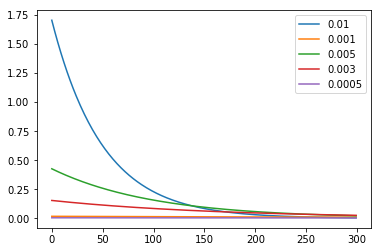

In [87]:
plots = []
for alpha in [0.01, 0.001, 0.005, 0.003, 0.0005]:
    theta, qual = gradientDescent(X, Y, np.zeros(n), alpha, 300)
    p, = plt.plot(range(0, len(qual)), qual, label=str(alpha))
    plots.append(p)
plt.legend(handles=plots)

Попробуем реализовать blending моделей

In [26]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

class MixinClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, first_model, second_model, alpha=0.5):
        self.first_model = first_model
        self.second_model = second_model
        self.alpha = alpha

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.first_model.fit(X, y)
        self.second_model.fit(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)
        return (self.first_model.predict(X)*self.alpha + self.second_model.predict(X)*(1-self.alpha)).round()
    
    def predict_proba(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)
        return (self.first_model.predict_proba(X)*self.alpha + self.second_model.predict_proba(X)*(1-self.alpha)).round()

In [27]:
best_mixin = run_search(
    X, Y,
    MixinClassifier(
        best_clfs['RandomForestClassifier'],
        best_clfs['LogisticRegression']
    ), 
    {'alpha': [0.4]}
)

Best score: 1189241.1851804124


In [30]:
def total_trasform(X):
    X['pickup_dt'] = X['pickup_dt'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").time())
    X['pickup_dt'] = X['pickup_dt'].apply(lambda x: x.second+x.minute*60+x.hour*3600)
    X['hday'] = X['hday'].apply(lambda x: 0 if x == 'N' else 1)
    for column_name in ['pickup_dt', 'spd', 'vsb', 'temp', 'dewp', 
                        'slp', 'pcp01', 'pcp06', 'pcp24', 'sd']:
        X[column_name] = normalize(X[column_name])
    for value in set(X['borough'].values):
        new_value = 'borough_{}'.format(value)
        X[new_value] = (X['borough'] == value)    
    del X_target['borough']
    del X['borough_nan']
    del X['id']
    return X

clf = best_mixin
X_target = pd.read_csv('data/testX.csv')
# or whatever
prediction = pd.DataFrame()
prediction['id'] = [str(item) for item in X_target['id']]

X_target = total_trasform(X_target)
predict_res = clf.predict(X_target)
prediction['pickups'] = predict_res
prediction.to_csv('data/baseline.csv', index=None)